
# Support Vector Machines on the D-Wave Quantum Annealer
#### Created by Gabriele Cavallaro (g.cavallaro@fz-juelich.de)
#### Modified for the paper __Hybrid Quantum Technologies For Quantum Support Vector Machines__ by Filippo Orazi (filippo.orazi2@unibo.it)


### 0. Setting Up the Access to the D-Wave quantum computer

- Make a free account to run on the D-Wave through [Leap](https://www.dwavesys.com/take-leap)

- Install Ocean Software with [pip install dwave-ocean-sdk](https://docs.ocean.dwavesys.com/en/latest/overview/install.html)

- Configuring the D-Wave System as a Solver with [dwave config create](https://docs.ocean.dwavesys.com/en/latest/overview/dwavesys.html#dwavesys)


You should create the folder tree as below 

current_folder
- input_datasets
  - calibration
    - dataset_name1
    - dataset_name2
  - train
    - dataset_name1
    - dataset_name2
- outputs
  - calibration
    - dataset_name1
    - dataset_name2
  - train
    - dataset_name1
    - dataset_name2
  - test
    - dataset_name1
    - dataset_name2


### 1. Data Preparation

#### 1.1 Load of the Python Modules

In [1]:
import sys;
sys.path.append("./..") 
from utils import * # It contains functions for threat the data (I/O, encoding/decoding) and metrics for evaluations 
from quantum_SVM import *
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from quantum_SVM import *
import numpy as np
from utils import *
from sklearn.model_selection import KFold


#### 1.2 Select the Dataset

##### In this notebook we consider the datasets of [HyperLabelMe](http://hyperlabelme.uv.es/index.html) (i.e., a benchmark system for remote sensing image classification). 

- It contains 43 image datasets, both multi- and hyperspectral
- For each one, training pairs (spectra and their labels) and test spectra are provided
- The test labels are not given. The predicted labels needs to be uploaded in HyperLabelMe which will return the accuracy


In [2]:

# Gamma is the number of feature used and the number of qubit in the QgSVM for this implementation
gamma=2

# You can also import your own dataset as long as it is correcly shaped and preprocessed

id_dataset='MNIST56'
[X_train,X_test, Y_train, Y_test ]=load(id_dataset, gamma)

loading dataset MNIST with classes '5' and '6'


2023-11-28 18:15:24.540844: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 18:15:24.540881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 18:15:24.543557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 18:15:26.855809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


25.4% of total variance is explained by 2 principal components


(<Figure size 1300x300 with 1 Axes>, <Axes: >)

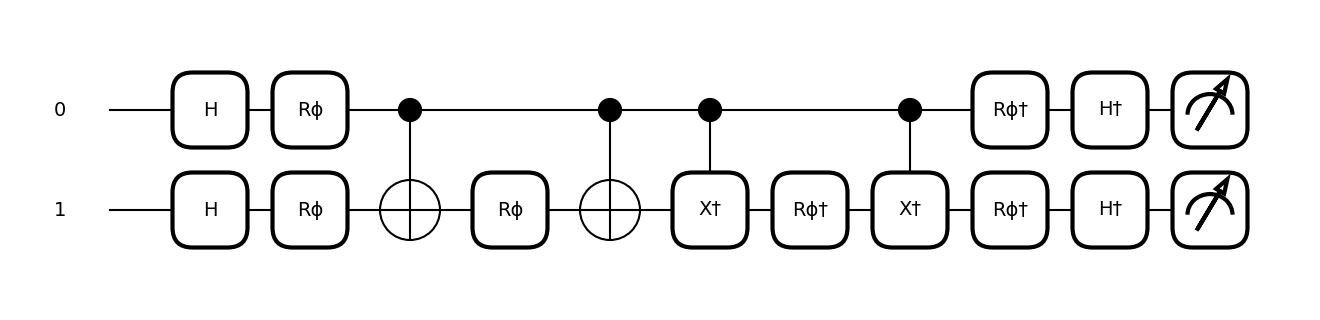

In [15]:
# Gamma is very important in our architecture because it gives dimentions to the QgSVM
# This is the architecture we used with four fake parameters
import pennylane as qml

qgsvm = QgSVM(gamma,"default.qubit")
qml.draw_mpl(qgsvm.get_fidelity())([0,0,0,0])



#### 1.5 Quantum SVM: Calibration Phase

The SVM on the QA depends on four hyperparameters:
the encoding base $B$, the number $K$ of qubits per coefficient $\alpha_{n}$, the multiplier $\xi$, and the kernel parameter $\gamma$. The parameter $n_{cpl}$ varies for each run  and is not a parameter of the SVM itself. 

The hyperparameters are selected through a 4-fold cross-validation. Each training set includes only 120 samples (i.e., choice due to the limitations of the QA). The validation includes the remaining samples that are used for the evaluation of the performance.  

For each dataset, the values are calibrated by evaluating the SVM for $B \in \{2, 10\}$, $K\in \{2, 3\}$, and $\xi \in \{1,2\}$  



In [ ]:

# 10-fold Monte Carlo (or split-and-shuffle) cross-validation
fold=4

for i in range(0,fold):
    X_train_cal, X_val_cal, Y_train_cal, Y_val_cal = train_test_split(X_train,Y_train, test_size=0.6, random_state=i)
    
   # Write the data
    write_samples(X_train_cal, Y_train_cal,'input_datasets/calibration/'+id_dataset+'/'+id_dataset+'calibtrain'+str(i))
    write_samples(X_val_cal, Y_val_cal,'input_datasets/calibration/'+id_dataset+'/'+id_dataset+'calibval'+str(i))
    
print('Each training set includes '+str(X_train_cal.shape[0])+ ' samples')
print('Each validation set includes '+str(X_val_cal.shape[0])+ ' samples')

In [ ]:

# Choose your Hyperparameters 
K=[2]
B=[2]
xi=[2]
n_experiments=len(B)*len(K)*len(xi)


hyperparameters=np.zeros([n_experiments,4], dtype=float)

path_data_key='input_datasets/calibration/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_out='outputs/calibration/'+id_dataset+'/'

trainacc=np.zeros([fold], dtype=float)
trainauroc=np.zeros([fold], dtype=float)
trainauprc=np.zeros([fold], dtype=float)
    
testacc=np.zeros([fold], dtype=float)
testauroc=np.zeros([fold], dtype=float)
testauprc=np.zeros([fold], dtype=float)

trainacc_all=np.zeros([n_experiments], dtype=float)
trainauroc_all=np.zeros([n_experiments], dtype=float)
trainauprc_all=np.zeros([n_experiments], dtype=float)
    
testacc_all=np.zeros([n_experiments], dtype=float)
testauroc_all=np.zeros([n_experiments], dtype=float)
testauprc_all=np.zeros([n_experiments], dtype=float)


f = open(path_out+'calibration_results.txt',"w") 
f.write("B\t K\t xi\t   gamma\t trainacc\t trainauroc\t trainauprc\t testacc\t testauroc\t testauprc\n") 
  
count=0 
for x in range(0,len(B)):
    for y in range(0,len(K)):
        for z in range(0,len(xi)):
            for i in range(0,1): # here the author loop over gamma that is fixed in our implementation
                for j in range(0,fold):
                    path=gen_svm_qubos(B[x],K[y],xi[z],gamma,path_data_key,data_key+str(j),path_out)
                    pathsub=dwave_run(path_data_key,path)
                    [trainacc[j],trainauroc[j],trainauprc[j],testacc[j],testauroc[j],testauprc[j]]=eval_run_rocpr_curves(path_data_key,pathsub,'noplotsave')
                    
                hyperparameters[count,0]=B[x]
                hyperparameters[count,1]=K[y]
                hyperparameters[count,2]=xi[z]
                hyperparameters[count,3]=gamma
            
                trainacc_all[count]=np.average(trainacc)
                trainauroc_all[count]=np.average(trainauroc)
                trainauprc_all[count]=np.average(trainauprc)
    
                testacc_all[count]=np.average(testacc)
                testauroc_all[count]=np.average(testauroc)
                testauprc_all[count]=np.average(testauprc)
                
                np.save(path_out+'hyperparameters', hyperparameters)
                np.save(path_out+'trainacc_all', trainacc_all)
                np.save(path_out+'trainauroc_all', trainauroc_all)
                np.save(path_out+'trainauprc_all', trainauprc_all)
                np.save(path_out+'testacc_all', testacc_all)
                np.save(path_out+'testauroc_all', testauroc_all)
                np.save(path_out+'testauprc_all', testauprc_all)
                
                f.write(f'{B[x]}\t {K[y]}\t {xi[z]}\t {gamma:8.3f}\t {np.average(trainacc):8.4f}\t {np.average(trainauroc):8.4f}\t {np.average(trainauprc):8.4f}\t {np.average(testacc):8.4f}\t {np.average(testauroc):8.4f}\t {np.average(testauprc):8.4f}')
                f.write("\n") 
                count=count+1
                
f.close() 

#### 1.6 Quantum SVM: Training Phase

To overcome the problem of the limited connectivity of the hardware the whole training set is split into small disjoint subsets $D^{(train,l)}$ of $~50$ samples, with $l=0,...,int(N/50)$. 
The strategy is to build an ensemble of quantum weak SVMs (qeSVMs) where each classifier is trained on $D^{(train,l)}$. 
This is achieved in two steps. First, for each subset $D^{(train,l)}$ the twenty best solutions from the annealer (i.e., qSVM$(B, K, \xi , \gamma )\#i$ for $i =0, ... ,19$) are combined by averaging over the respective decision functions $f^{l,i}(\mathbf{x})$ (see Eq. (3)). 

Since the decision function is linear in the coefficients
and the bias $b^{(l,i)}$ is computed from $\alpha_{n}^{(l,i)}$ via Eq. (4), this procedure effectively results in one classifier with an effective set of coefficients 
$\alpha_{n}^{(l)}=\sum_{i} \alpha_{n}^{(l, i)} / 20$ and bias 
$b^{l}=\sum_{i} b^{(l, i)} / 20$.
Second, an average is made over the $int(N/50)$ subsets. 

Note, however, that the data points 
$\left(\mathbf{x}_{n}^{(l)}, y_{n}^{(l)}\right) \in D^{(\text {train }, l)}$ are now different for each $l$. The full decision function is

\begin{equation}
F(\mathbf{x})=\frac{1}{L} \sum_{n l} \alpha_{n}^{(l)} y_{n}^{(l)} k\left(\mathbf{x}_{n}^{(l)}, \mathbf{x}\right)+b,
\end{equation}

where $b=\sum_{l} b^{(l)} / L$. As before, the decision for the class label of a point $\mathbf{x}$ is obtained through $\widetilde{t}=\operatorname{sign}(F(\mathbf{x}))$. 


In [ ]:
#Training parameters
experiments=1
slice=50 # Number of samples to use for the training
fold=int(len(X_train)/slice)

# Write the data

 
for i in range(0,experiments):    
    cv = KFold(n_splits=fold, random_state=i, shuffle=True)
    count=0
    for test_index, train_index in cv.split(X_train):
        #print("Train Index: ", len(train_index), "\n")
        
        X_train_slice, y_train_slice = X_train[train_index], Y_train[train_index]
        #X_train_slice = preprocessing.scale(X_train_slice)
        
        X_test_slice, y_test_slice = X_train[test_index], Y_train[test_index]
        #X_test_slice = preprocessing.scale(X_test_slice)
        
        write_samples(X_train_slice, y_train_slice,f'input_datasets/train/'+id_dataset+'/'+id_dataset+'calibtrain'+str(i)+'_'+str(count))
        write_samples(X_test_slice, y_test_slice,f'input_datasets/train/'+id_dataset+'/'+id_dataset+'calibval'+str(i)+'_'+str(count))
        
        count=count+1
print(f'the training set has {fold} folds')
print("Each training set has", len(train_index), "samples\n")

In [ ]:
# Get the calibration results
path_out='outputs/calibration/'+id_dataset+'/'
hyperparameters=np.load(path_out+'hyperparameters.npy')
testauprc_all=np.load(path_out+'testauprc_all.npy')

# Select the best hyperparameter set for the max value of testauprc
idx_max = np.where(testauprc_all == np.amax(testauprc_all))
B=int(hyperparameters[int(idx_max[0]),0])
K=int(hyperparameters[int(idx_max[0]),1])
xi=int(hyperparameters[int(idx_max[0]),2])
print('The best hyperparameters are:\n'+'B = '+str(B)+' K = '+str(K)+' xi = '+str(xi)+' gamma = '+str(gamma))


In [ ]:
# once the best hyperparameter are found we can see the QUBO matrix (at least for a portion of the dataset)
path_data_key='input_datasets/train/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_out='outputs/train/'+id_dataset+'/'
Q=gen_svm_qubos(B,K,xi,gamma,path_data_key,data_key+str(0)+'_'+str(0),path_out, return_QUBO=True)
sns.heatmap(Q)


In [ ]:
#and we can complete the training 

path_data_key='input_datasets/train/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_out='outputs/train/'+id_dataset+'/'

trained_SVMs=[]

for j in range(0,experiments):
    for i in range(0,fold):
        path=gen_svm_qubos(B,K,xi,gamma,path_data_key,data_key+str(j)+'_'+str(i),path_out)
        trained_SVMs.append(dwave_run(path_data_key,path))
        np.save(path_out+'trained_SVMs',trained_SVMs)   

#### 1.7 Quantum SVM: Test Phase
 
The performance of the qeSVMs can be evaluated directly on [HyperLabelMe](http://hyperlabelme.uv.es/index.html) by uploading the predictions (i.e., output file of the next cell)

In [ ]:
path_data_key='input_datasets/train/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_train_out='outputs/train/'+id_dataset+'/'
path_test_out='outputs/test/'+id_dataset+'/'

path_files=np.load(path_train_out+'trained_SVMs.npy')

experiments=1
slices=6
scores=[]
for j in range(0,experiments):
    for i in range(0,slices):
        scores.append(predict(path_data_key, [i],X_test))
 
avg_scores=np.zeros((scores[0].shape[0]))
Y_predicted=np.zeros((scores[0].shape[0]),int)
    
for i in range(0,scores[0].shape[0]):
    tmp=0
    for y in range(0,slices):
        tmp=tmp+np.sign(scores[y][i])
    avg_scores[i]=tmp   


for i in range(0,scores[0].shape[0]):
    if(avg_scores[i]<0):
        Y_predicted[i]=-1
    else:
        Y_predicted[i]=1
        

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(Y_predicted, Y_test)/len(Y_predicted),annot=True)
classification_report(Y_predicted, Y_test)
